#  Naïve Bayes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [2]:
df_train = pd.read_csv('fashion-mnist_train.csv').values
df_test = pd.read_csv('fashion-mnist_test.csv').values
selector = [x for x in range(df_train.shape[1]) if x != 0]
train_images = df_train[:,selector]
train_labels = df_train[:,0]
test_images = df_test[:,selector]
test_labels = df_test[:,0]
N_data = train_images.shape[0]

In [39]:
train_labels_array = np.zeros([60000,10], int)
for i in range(len(train_labels)):
    train_labels_array[i,train_labels[i]] = 1

test_labels_array = np.zeros([10000,10], int)
for i in range(len(test_labels)):
    test_labels_array[i,test_labels[i]] = 1

In [40]:
train_labels = train_labels_array
test_labels = test_labels_array

In [41]:
train_images= np.where(train_images<127.5, 0.0, train_images)
train_images = np.where(train_images>127.5, 1.0, train_images)
test_images = np.where(test_images<127.5, 0.0, test_images)
test_images = np.where(test_images>127.5, 1.0, test_images)

In [42]:
def train_map_estimator(train_images, train_labels):
    """ Inputs: train_images (N_samples x N_features), train_labels (N_samples x N_classes)
        Returns the MAP estimator theta_est (N_features x N_classes) and the MLE
        estimator pi_est (N_classes)"""
    pi_est = np.mean(train_labels, 0)
    theta_est = (1 + np.matmul(train_images.T, train_labels)) / (2 + np.sum(train_labels, 0))
    return theta_est, pi_est

In [43]:
from numpy.core.fromnumeric import argmax

from numpy.ma.core import log
def log_likelihood(images, theta, pi):
    """ 
    Inputs: images (N_samples x N_features), theta, pi
    Returns the matrix 'log_like' of loglikehoods over the input images 
    """

    p_c_given_pi = pi
    log_p_c_given_pi = np.log(pi)
    log_p_x_given_c_theta = np.matmul(images,np.log(theta))+(np.matmul(1-images,np.log(1-theta)))
    log_p_c_x_given_theta_pi = log_p_c_given_pi + log_p_x_given_c_theta

    p_x_given_c_theta = np.exp(log_p_x_given_c_theta)
    p_x_given_theta_pi = np.matmul(p_x_given_c_theta, p_c_given_pi)
    p_x_given_theta_pi = np.where(p_x_given_theta_pi==0, 2.2250738585072014e-308,p_x_given_theta_pi)
    log_p_x_given_theta_pi = np.log(p_x_given_theta_pi).reshape(-1, 1)
    

    log_like = log_p_c_given_pi + log_p_x_given_c_theta - log_p_x_given_theta_pi
    return log_like



theta_est, pi_est = train_map_estimator(train_images, train_labels)
loglike_test = log_likelihood(test_images, theta_est, pi_est)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
test_labels_pred = np.array(np.argmax(loglike_test, 1))
test_label_1d = np.array(np.argmax(test_labels, 1))


confusion_matrix = confusion_matrix(test_label_1d, test_labels_pred)

print("\n Accuracy score\n", accuracy_score(test_label_1d, test_labels_pred))
print("\n F1 score\n", f1_score(test_label_1d, test_labels_pred,  average = 'macro'))
print("\n Confusion Matrix\n", confusion_matrix)
print("\n Classification Report\n", classification_report(test_label_1d, test_labels_pred))


 Accuracy score
 0.6576

 F1 score
 0.6483885043254971

 Confusion Matrix
 [[611  10  24 100  25 166  39   1  24   0]
 [ 25 896   9  33  10  15  12   0   0   0]
 [  9   1 320   7 359 176 108   0  20   0]
 [ 36  23   5 770  49  95  21   0   1   0]
 [  0   5  45  77 720  82  65   0   6   0]
 [  0   0   0   0   0 735  10 191   8  56]
 [167   5  66  58 267 277 135   0  24   1]
 [  0   0   0   0   0 147   0 780   0  73]
 [  2   1   7  37  10 113  44  13 772   1]
 [  0   0   4   0   1  74  11  71   2 837]]

 Classification Report
               precision    recall  f1-score   support

           0       0.72      0.61      0.66      1000
           1       0.95      0.90      0.92      1000
           2       0.67      0.32      0.43      1000
           3       0.71      0.77      0.74      1000
           4       0.50      0.72      0.59      1000
           5       0.39      0.73      0.51      1000
           6       0.30      0.14      0.19      1000
           7       0.74      0.78  

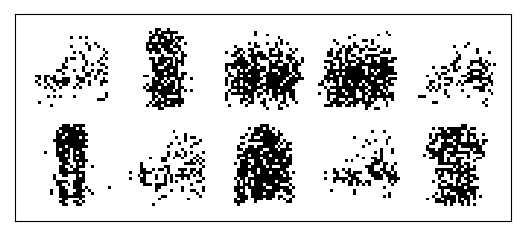

In [44]:
def image_sampler(theta, pi, num_images):
    """ Inputs: parameters theta and pi, and number of images to sample
    Returns the sampled images (N_images x N_features)"""
    N_classes = pi.shape[0]
    N_features = theta.shape[0]
    sampled_images = np.zeros((num_images, N_features))
    
    for i in range(num_images):
        c = np.random.choice(N_classes, size=1, p=pi)[0]
        sampled_images[i, :] = np.random.binomial(1, theta[:, c], size=N_features)
        
    return sampled_images


def plot_images(images, ims_per_row=5, padding=5, image_dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=0., vmax=1.):
    """Images should be a (N_images x pixels) matrix."""
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)

    N_images = images.shape[0]
    N_rows = np.int32(np.ceil(float(N_images) / ims_per_row))
    pad_value = vmin
    concat_images = np.full(((image_dimensions[0] + padding) * N_rows + padding,
                             (image_dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], image_dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + image_dimensions[0]) * row_ix
        col_start = padding + (padding + image_dimensions[1]) * col_ix
        concat_images[row_start: row_start + image_dimensions[0],
                      col_start: col_start + image_dimensions[1]] = cur_image
        cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    
    plt.plot()


sampled_images = image_sampler(theta_est, pi_est, 10)
plot_images(sampled_images)

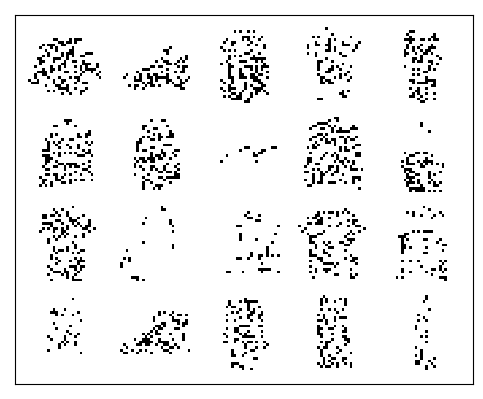

In [45]:
def probabilistic_imputer(theta, pi, original_images, is_observed):
    """
    Inputs: parameters theta and pi, original_images, 
    and is_observed which has the same shape as original_images
    Returns the new images where unobserved pixels are replaced by their 
    conditional probability
    """
    
    N_images,N_features = original_images.shape
    imputed_images = original_images
    C = theta.shape[0]

    for image in range(N_images):
      x_E = original_images[image][is_observed[image] == 1]
      P_X_E = np.exp(np.log(theta[is_observed[image] == 1].T)@ x_E + 
                     np.log(1 - theta[is_observed[image] == 1].T)@ (1 - x_E))
      denominator = np.sum(P_X_E * pi) 
      numerator = np.sum(P_X_E *  theta[is_observed[image] == 0] * pi, axis = 1)
      p_x_j = numerator / denominator
      imputed_images[image, is_observed[image] == 0] = p_x_j

    return imputed_images


num_features = train_images.shape[1]
is_observed = np.random.binomial(1, p=0.3, size=(20, num_features))
plot_images(train_images[:20] * is_observed)

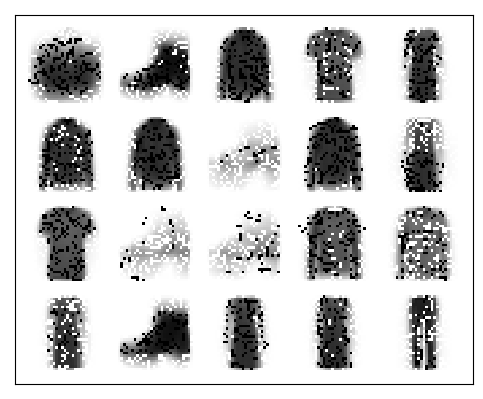

In [46]:
imputed_images = probabilistic_imputer(theta_est, pi_est, train_images[:20], is_observed)
plot_images(imputed_images)

#  Logistic regression

In [47]:
train_images_LG = df_train[:,selector]/ 255.0
train_labels_LG = df_train[:,0]
test_images_LG = df_test[:,selector]/ 255.0
test_labels_LG = df_test[:,0]
N_data_LG = train_images.shape[0]

In [48]:
from sklearn.decomposition import PCA

# Build a PCA model to retain 97% of the information
pca = PCA(.97)

# Fit the model to the data
pca.fit(train_images_LG)

# Transform the data to reduce dimensionality using PCA
train_images_LG_PCA = pca.transform(train_images_LG)
test_images_LG_PCA = pca.transform(test_images_LG)

print(train_images_LG_PCA.shape)
print(test_images_LG_PCA.shape)


(60000, 277)
(10000, 277)


In [49]:
from sklearn.linear_model import LogisticRegression
best_accuracy = 0

# Possible kernels
solver_option = ['sag', 'saga', 'lbfgs', 'newton-cg']
C_option = [0.01, 0.05, 0.1, 0.5, 1, 5, 10]

for SOLVER in solver_option:
    for C_op in C_option:
        C = C_op/100

        # Create the model
        LG_model = LogisticRegression(C = C, max_iter = 1000, n_jobs = -1, solver = SOLVER)
        LG_model.fit(train_images_LG_PCA, train_labels_LG)

        # Predict labels for the test set
        predicted_LG = LG_model.predict(test_images_LG_PCA)
        AC_score = accuracy_score(test_labels_LG, predicted_LG)

        print("\nTesting ", SOLVER, " solver with C = ", C)
        print("\n Accuracy score for ", SOLVER, " solver with C = ", C, " is ", AC_score)

        if AC_score > best_accuracy:
            best_accuracy = accuracy_score(test_labels_LG, predicted_LG)
            best_params = [SOLVER, C]

print("\nOptimisaion Finished. Best Score is ", best_accuracy, "\nBest parameters are ", best_params)


Testing  sag  solver with C =  0.0001

 Accuracy score for  sag  solver with C =  0.0001  is  0.7591

Testing  sag  solver with C =  0.0005

 Accuracy score for  sag  solver with C =  0.0005  is  0.8082

Testing  sag  solver with C =  0.001

 Accuracy score for  sag  solver with C =  0.001  is  0.8226

Testing  sag  solver with C =  0.005

 Accuracy score for  sag  solver with C =  0.005  is  0.8469

Testing  sag  solver with C =  0.01

 Accuracy score for  sag  solver with C =  0.01  is  0.8519

Testing  sag  solver with C =  0.05

 Accuracy score for  sag  solver with C =  0.05  is  0.8547

Testing  sag  solver with C =  0.1

 Accuracy score for  sag  solver with C =  0.1  is  0.8567

Testing  saga  solver with C =  0.0001

 Accuracy score for  saga  solver with C =  0.0001  is  0.7592

Testing  saga  solver with C =  0.0005

 Accuracy score for  saga  solver with C =  0.0005  is  0.8082

Testing  saga  solver with C =  0.001

 Accuracy score for  saga  solver with C =  0.001  is  0

In [50]:
# Assign optimised parameters to the hyperparameters for the model
S = best_params[0]
C = best_params[1]

In [51]:
# Create the model with the optimised parameters
model = LogisticRegression(C = C, max_iter = 10000, n_jobs = -1, solver = S)
model.fit(train_images_LG_PCA, train_labels_LG)

# Predict labels for the test set
predicted_LG = model.predict(test_images_LG_PCA)

# Evaluate the model
confusion_matrix = confusion_matrix(test_labels_LG, predicted_LG)

print("\n Accuracy score\n", accuracy_score(test_labels_LG, predicted_LG))
print("\n F1 score\n", f1_score(test_labels_LG, predicted_LG,  average = 'macro'))
print("\n Confusion Matrix\n", confusion_matrix)
print("\n Classification Report\n", classification_report(test_labels_LG, predicted_LG))


 Accuracy score
 0.8567

 F1 score
 0.8556865676404998

 Confusion Matrix
 [[821   4  14  45   1   4  95   0  15   1]
 [  1 971   3  16   1   2   6   0   0   0]
 [ 13   2 765  11 111   0  87   0  11   0]
 [ 34  20  16 884  19   0  26   0   1   0]
 [  1   0  82  30 810   0  74   0   3   0]
 [  1   1   0   1   0 919   1  51   6  20]
 [153   4 106  31  92   1 597   0  16   0]
 [  0   0   0   0   0  39   0 911   1  49]
 [  6   0   7   4   4   7  18   4 948   2]
 [  0   0   0   0   0  17   0  42   0 941]]

 Classification Report
               precision    recall  f1-score   support

           0       0.80      0.82      0.81      1000
           1       0.97      0.97      0.97      1000
           2       0.77      0.77      0.77      1000
           3       0.86      0.88      0.87      1000
           4       0.78      0.81      0.79      1000
           5       0.93      0.92      0.92      1000
           6       0.66      0.60      0.63      1000
           7       0.90      0.91  

#  Support Vector Machine (SVM)

In [4]:
train_images_SVM = df_train[:,selector]/255.0
train_labels_SVM = df_train[:,0]
test_images_SVM = df_test[:,selector]/ 255.0
test_labels_SVM = df_test[:,0]
N_data_SVM = train_images.shape[0]
from sklearn.svm import SVC

In [5]:
from sklearn.decomposition import PCA

pca = PCA(.97)
pca.fit(train_images_SVM)
train_images_SVM_PCA = pca.transform(train_images_SVM)
test_images_SVM_PCA = pca.transform(test_images_SVM)
print(train_images_SVM_PCA.shape)
print(test_images_SVM_PCA.shape)

(60000, 277)
(10000, 277)


In [10]:
from sklearn.svm import SVC # "Support vector classifier"

# Set best accuracy to a small value initially
best_accuracy = - 1

# possible kernels
kernel_option = ['linear', 'rbf', 'poly']

# Define the values each hyperparameter can take
C_option = [0.01, 0.05, 0.1, 0.5, 1]
degree_option = [3, 4, 5]

for C_op in C_option:
    print("\nTesting C = ", C_op)

    # Create a model
    model = SVC(C = C_op, kernel = 'linear')
    model.fit(train_images_SVM_PCA, train_labels_SVM)

    # Predict labels for the test set
    predicted_labels_SVM = model.predict(test_images_SVM_PCA)
    print("\n Accuracy score for LINEAR solver with C = ", C_op, " is ",
          accuracy_score(test_labels_SVM, predicted_labels_SVM))

    if accuracy_score(test_labels_SVM, predicted_labels_SVM) > best_accuracy:
        best_accuracy = accuracy_score(test_labels_SVM, predicted_labels_SVM)
        best_params = ['linear', C_op]
        print("\nNew best accuracy score: ", accuracy_score(test_labels_SVM, predicted_labels_SVM))

print("\n\n ! Finished with Linear.\n Best parameters are: ", best_params, "\nAccuracy for them is ", best_accuracy)


Testing C =  0.01

 Accuracy score for LINEAR solver with C =  0.01  is  0.8647

New best accuracy score:  0.8647

Testing C =  0.05

 Accuracy score for LINEAR solver with C =  0.05  is  0.865

New best accuracy score:  0.865

Testing C =  0.1

 Accuracy score for LINEAR solver with C =  0.1  is  0.8641

Testing C =  0.5

 Accuracy score for LINEAR solver with C =  0.5  is  0.861

Testing C =  1

 Accuracy score for LINEAR solver with C =  1  is  0.8591


 ! Finished with Linear.
 Best parameters are:  ['linear', 0.05] 
Accuracy for them is  0.865


In [11]:
for C_op in C_option:
    print("\nTesting C = ", C_op)

    model = SVC(C = C_op, kernel = 'rbf')
    model.fit(train_images_SVM_PCA, train_labels_SVM)

    predicted_SVM = model.predict(test_images_SVM_PCA)
    print("\n Accuracy score for RBF solver with C = ", C_op, " is ",
          accuracy_score(test_labels_SVM, predicted_SVM))

    if accuracy_score(test_labels_SVM, predicted_SVM) > best_accuracy:
        best_accuracy = accuracy_score(test_labels_SVM, predicted_SVM)
        best_params = ['rbf', C_op]
        print("\nNew best accuracy score: ", accuracy_score(test_labels_SVM, predicted_SVM))
print("\n\n ! Finished with RBF.\n Best parameters are: ", best_params, "\nAccuracy for them is ", best_accuracy)


Testing C =  0.01

 Accuracy score for RBF solver with C =  0.01  is  0.7949

Testing C =  0.05

 Accuracy score for RBF solver with C =  0.05  is  0.8432

Testing C =  0.1

 Accuracy score for RBF solver with C =  0.1  is  0.8633

Testing C =  0.5

 Accuracy score for RBF solver with C =  0.5  is  0.8891

New best accuracy score:  0.8891

Testing C =  1

 Accuracy score for RBF solver with C =  1  is  0.8971

New best accuracy score:  0.8971


 ! Finished with RBF.
 Best parameters are:  ['rbf', 1] 
Accuracy for them is  0.8971


In [13]:
for C_op in C_option:
    print("\nTesting C = ", C_op)
    for D in degree_option:
        print("\nTesting Degree = ", D)

        model = SVC(C = C_op, kernel = 'poly', degree = D)
        model.fit(train_images_SVM_PCA, train_labels_SVM)

        predicted_SVM = model.predict(test_images_SVM_PCA)
        print("\n Accuracy score for Poly solver with C = ", C_op, " Degree = ", D, " is ",
              accuracy_score(test_labels_SVM, predicted_SVM))

        if accuracy_score(test_labels_SVM, predicted_SVM) > best_accuracy:
            best_accuracy = accuracy_score(test_labels_SVM, predicted_SVM)
            best_params = ['poly', C_op, D]
            print("\nNew best accuracy score: ", accuracy_score(test_labels_SVM, predicted_SVM))

print("\nOptimisaion Finished. Best Score is ", best_accuracy, "\nBest parameters are ", best_params)


Testing C =  0.01

Testing Degree =  3

 Accuracy score for Poly solver with C =  0.01  Degree =  3  is  0.7235

Testing Degree =  4

 Accuracy score for Poly solver with C =  0.01  Degree =  4  is  0.6589

Testing Degree =  5

 Accuracy score for Poly solver with C =  0.01  Degree =  5  is  0.6283

Kernel not recognised.

Testing C =  0.05

Testing Degree =  3

 Accuracy score for Poly solver with C =  0.05  Degree =  3  is  0.8152

Testing Degree =  4

 Accuracy score for Poly solver with C =  0.05  Degree =  4  is  0.762

Testing Degree =  5

 Accuracy score for Poly solver with C =  0.05  Degree =  5  is  0.7228

Kernel not recognised.

Testing C =  0.1

Testing Degree =  3

 Accuracy score for Poly solver with C =  0.1  Degree =  3  is  0.8436

Testing Degree =  4

 Accuracy score for Poly solver with C =  0.1  Degree =  4  is  0.8013

Testing Degree =  5

 Accuracy score for Poly solver with C =  0.1  Degree =  5  is  0.76

Kernel not recognised.

Testing C =  0.5

Testing Degre

In [14]:
K = best_params[0]
C = best_params[1]
if len(best_params) == 3:
    DEGREE = best_params[2]

In [15]:
model = SVC(C = C, cache_size=1000, kernel=K, random_state = None)
model.fit(train_images_SVM_PCA, train_labels_SVM)

# Predict labels for the test set
predicted_SVM = model.predict(test_images_SVM_PCA)

# Evaluate the model
confusion_matrix = confusion_matrix(test_labels_SVM, predicted_SVM)

print("\n Accuracy score\n", accuracy_score(test_labels_SVM, predicted_SVM))
print("\n F1 score\n", f1_score(test_labels_SVM, predicted_SVM,  average = 'macro'))
print("\n Confusion Matrix\n", confusion_matrix)
print("\n Classification Report\n", classification_report(test_labels_SVM, predicted_SVM))


 Accuracy score
 0.8971

 F1 score
 0.8965721739381616

 Confusion Matrix
 [[861   0  11  24   0   2  93   0   9   0]
 [  2 976   1  15   0   1   5   0   0   0]
 [ 10   0 827  14  79   0  68   0   2   0]
 [ 26   7   7 921  22   0  16   0   1   0]
 [  0   0  57  25 874   0  42   0   2   0]
 [  0   0   0   0   0 945   1  38   3  13]
 [149   0  75  27  56   0 685   0   8   0]
 [  0   0   0   0   0  18   0 950   0  32]
 [  4   0   6   3   1   2   7   2 975   0]
 [  0   0   0   0   0   9   0  34   0 957]]

 Classification Report
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.84      0.83      0.83      1000
           3       0.90      0.92      0.91      1000
           4       0.85      0.87      0.86      1000
           5       0.97      0.94      0.96      1000
           6       0.75      0.69      0.71      1000
           7       0.93      0.95  